In [308]:
#Data -> Teleco Customer Churn

In [309]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,accuracy_score, confusion_matrix, classification_report, recall_score,f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Load Data

In [310]:
data_set = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [311]:
print(data_set.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

# Pre-Processing Data

## Selecting Index

In [312]:
data_set['customerID'].is_unique #we will set it to the index, hence it's true.

True

In [313]:
data_set.set_index('customerID', inplace=True)

In [314]:
data_set.index

Index(['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', '7795-CFOCW', '9237-HQITU',
       '9305-CDSKC', '1452-KIOVK', '6713-OKOMC', '7892-POOKP', '6388-TABGU',
       ...
       '9767-FFLEM', '0639-TSIQW', '8456-QDAVC', '7750-EYXWZ', '2569-WGERO',
       '6840-RESVB', '2234-XADUH', '4801-JZAZL', '8361-LTMKD', '3186-AJIEK'],
      dtype='object', name='customerID', length=7043)

## Feature Engineering

In [315]:
data_set.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [316]:
data_set.shape

(7043, 20)

In [317]:
#removing all the null values
data_set.isnull().count()

,0
gender,7043
SeniorCitizen,7043
Partner,7043
Dependents,7043
tenure,7043
PhoneService,7043
MultipleLines,7043
InternetService,7043
OnlineSecurity,7043
OnlineBackup,7043


In [318]:
data_set['MultipleLines'].value_counts()

,count
MultipleLines,
No,3390
Yes,2971
No phone service,682


In [319]:
data_set['InternetService'].value_counts()

,count
InternetService,
Fiber optic,3096
DSL,2421
No,1526


In [320]:
data_set['Contract'].value_counts()

,count
Contract,
Month-to-month,3875
Two year,1695
One year,1473


In [321]:
data_set['PaymentMethod'].value_counts()

,count
PaymentMethod,
Electronic check,2365
Mailed check,1612
Bank transfer (automatic),1544
Credit card (automatic),1522


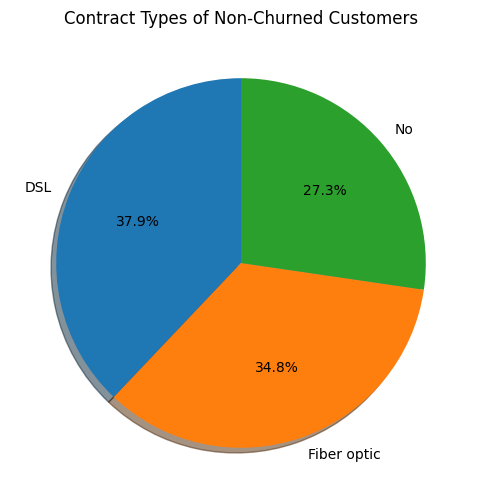

In [322]:
plt.figure(figsize=(55,15))
counts = data_set[data_set['Churn']== 'No']['InternetService'].value_counts()
# Plot as pie chart
counts.plot.pie(
    autopct='%1.1f%%',
    shadow=True,
    startangle=90,
    figsize=(6, 6),
    title='Contract Types of Non-Churned Customers'
)

plt.ylabel('')  # Optional: remove default y-axis label
plt.show()

In [323]:
data_set.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [324]:
#Selected Features

num_col = ['tenure','MonthlyCharges','TotalCharges']
cat_col = ['Partner','Dependents','MultipleLines','InternetService','Contract','PaymentMethod']
op_col = ['Churn']

In [325]:
features_clean = data_set[num_col + cat_col + op_col].copy()

In [326]:
features_clean.head()

,tenure,MonthlyCharges,TotalCharges,Partner,Dependents,MultipleLines,InternetService,Contract,PaymentMethod,Churn
customerID,,,,,,,,,,
7590-VHVEG,1,29.85,29.85,Yes,No,No phone service,DSL,Month-to-month,Electronic check,No
5575-GNVDE,34,56.95,1889.5,No,No,No,DSL,One year,Mailed check,No
3668-QPYBK,2,53.85,108.15,No,No,No,DSL,Month-to-month,Mailed check,Yes
7795-CFOCW,45,42.30,1840.75,No,No,No phone service,DSL,One year,Bank transfer (automatic),No
9237-HQITU,2,70.70,151.65,No,No,No,Fiber optic,Month-to-month,Electronic check,Yes


## Features Encoding

In [327]:
#Encoding Churn

features_clean['Churn'] = features_clean['Churn'].map({'Yes':1,'No':0})

#Changing dtype of TotalCharges
features_clean['TotalCharges'] = pd.to_numeric(features_clean['TotalCharges'], errors='coerce')
features_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tenure           7043 non-null   int64  
 1   MonthlyCharges   7043 non-null   float64
 2   TotalCharges     7032 non-null   float64
 3   Partner          7043 non-null   object 
 4   Dependents       7043 non-null   object 
 5   MultipleLines    7043 non-null   object 
 6   InternetService  7043 non-null   object 
 7   Contract         7043 non-null   object 
 8   PaymentMethod    7043 non-null   object 
 9   Churn            7043 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 863.3+ KB


In [328]:
#Label Encoding
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_col),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_col)
])

In [329]:
features_clean.head() #Seems Perfect

,tenure,MonthlyCharges,TotalCharges,Partner,Dependents,MultipleLines,InternetService,Contract,PaymentMethod,Churn
customerID,,,,,,,,,,
7590-VHVEG,1,29.85,29.85,Yes,No,No phone service,DSL,Month-to-month,Electronic check,0
5575-GNVDE,34,56.95,1889.50,No,No,No,DSL,One year,Mailed check,0
3668-QPYBK,2,53.85,108.15,No,No,No,DSL,Month-to-month,Mailed check,1
7795-CFOCW,45,42.30,1840.75,No,No,No phone service,DSL,One year,Bank transfer (automatic),0
9237-HQITU,2,70.70,151.65,No,No,No,Fiber optic,Month-to-month,Electronic check,1


In [330]:
features_clean = features_clean.dropna()

In [331]:
X = features_clean[num_col + cat_col]
y = features_clean['Churn']

# Splitting Data for training and testing

In [332]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)

In [333]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4219, 9) (2813, 9) (4219,) (2813,)


# Selecting Models

In [339]:
models = {
    'XGB' : XGBClassifier(n_estimators = 100, enable_categorical=True),
    'DT' : DecisionTreeClassifier(),
    'RF' : RandomForestClassifier(),
    'LR' : LogisticRegression(max_iter=1000)
}

# Model Evaluation

In [356]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline

results = []
fitted_models = {}  # 🔥 Store trained pipelines by name

# Loop through each model
for name, base_model in models.items():
    # Create pipeline
    model = Pipeline([
        ('preprocess', preprocessor),
        ('clf', base_model)
    ])

    # Fit model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Save trained model
    fitted_models[name] = model  # ✅ Store the actual model

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Save metrics
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })

# Create and print results DataFrame
results_df = pd.DataFrame(results)
print(results_df)

  Model  Accuracy  Precision    Recall  F1 Score
0   XGB  0.769996   0.565022  0.514986  0.538845
1    DT  0.728048   0.480154  0.510899  0.495050
2    RF  0.776040   0.584691  0.489101  0.532641
3    LR  0.794525   0.629568  0.516349  0.567365


In [343]:
features_clean.head()

,tenure,MonthlyCharges,TotalCharges,Partner,Dependents,MultipleLines,InternetService,Contract,PaymentMethod,Churn
customerID,,,,,,,,,,
7590-VHVEG,1,29.85,29.85,Yes,No,No phone service,DSL,Month-to-month,Electronic check,0
5575-GNVDE,34,56.95,1889.50,No,No,No,DSL,One year,Mailed check,0
3668-QPYBK,2,53.85,108.15,No,No,No,DSL,Month-to-month,Mailed check,1
7795-CFOCW,45,42.30,1840.75,No,No,No phone service,DSL,One year,Bank transfer (automatic),0
9237-HQITU,2,70.70,151.65,No,No,No,Fiber optic,Month-to-month,Electronic check,1


In [349]:
# Let's use Logistic Regression for better enhancement
new_customer = pd.DataFrame([{
    'tenure': 34,
    'MonthlyCharges': 43,
    'TotalCharges': 2200,
    'Partner': 'Yes',
    'Dependents': 'No',
    'MultipleLines': 'Yes',
    'InternetService': 'Fiber optic',
    'Contract': 'Month-to-month',
    'PaymentMethod': 'Bank transfer (automatic)'
}])

In [357]:
# Step 1: Get best model name
best_model_name = results_df.loc[results_df['F1 Score'].idxmax(), 'Model']
print("Best Model:", best_model_name)

# Step 2: Retrieve trained model
best_model = fitted_models[best_model_name]

# Step 4: Make prediction
prediction = best_model.predict(new_customer)
print("Churn prediction:", "Yes" if prediction[0] == 1 else "No")

# (Optional) Show churn probability
prob = best_model.predict_proba(new_customer)[0][1]
print(f"Churn probability: {prob:.2f}")


Best Model: LR
Churn prediction: No
Churn probability: 0.39


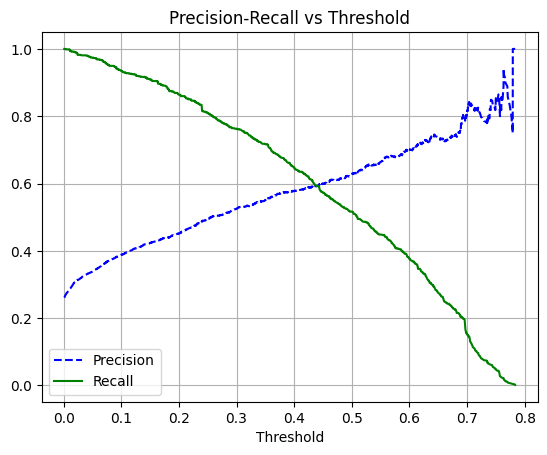

In [358]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_scores = best_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.title('Precision-Recall vs Threshold')
plt.grid(True)
plt.show()


In [359]:
#Import Model
import joblib

joblib.dump(best_model, 'best_churn_model.pkl')

['best_churn_model.pkl']

In [360]:
from google.colab import files  # Only for Colab
files.download('best_churn_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>